# Import from libraries

In [37]:
import numpy as np
import pandas as pd
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from matplotlib import pyplot
import os
import sys

from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator

#### Unzipping the dataset (if you downloaded it at "https://www.kaggle.com/c/dogs-vs-cats/data")

In [38]:
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/train.zip","r") as zip_ref:
    zip_ref.extractall("dogs-vs-cats")
    
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/test1.zip","r") as zip_ref:
    zip_ref.extractall("dogs-vs-cats")

In [39]:
files = os.listdir('/kaggle/working/dogs-vs-cats/train')

# Dataset configuration

In [40]:
category = []
for file in files:
    if file.split('.')[0] == 'dog':
        category.append('dog')
    else:
        category.append('cat')
    
train_df = pd.DataFrame({'file': files,
                        'label': category})

In [41]:
img_generator_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.3,
                                                                     rotation_range = 20, width_shift_range = 0.1,
                                                                     height_shift_range = 0.1, horizontal_flip = True
                                                                     )
img_generator_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_df.label.value_counts()

dog    12500
cat    12500
Name: label, dtype: int64

In [42]:
# Training data
train_set = img_generator_train.flow_from_dataframe(dataframe=train_df, directory="/kaggle/working/dogs-vs-cats/train",
                                                    x_col="file", y_col='label', batch_size=32, class_mode = 'binary',
                                                    seed=42, shuffle=False, target_size=(256,256), subset="training")

# Data for evaluation
val_set = img_generator_train.flow_from_dataframe(dataframe=train_df, directory="/kaggle/working/dogs-vs-cats/train",
                                                    x_col="file", y_col='label', batch_size=32, class_mode = 'binary',
                                                    seed=42, shuffle=False, target_size=(256,256), subset="validation")

Found 17500 validated image filenames belonging to 2 classes.
Found 7500 validated image filenames belonging to 2 classes.


# Model architecture

In [43]:
# define cnn model
def define_model():
    # load model
    model = Xception(include_top=False, input_shape=(256, 256, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Training

In [44]:
# define model
model = define_model()
# create data generator
datagen = ImageDataGenerator(featurewise_center=True)
# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
# prepare iterator
train_it = train_set
test_it = val_set
# fit model
history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
# evaluate model
_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))
model.save("my_model.h5")

83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/10
547/547 [==============================] - 406s 738ms/step - loss: 0.0748 - accuracy: 0.9730 - val_loss: 0.0377 - val_accuracy: 0.9852
Epoch 2/10
547/547 [==============================] - 399s 729ms/step - loss: 0.0327 - accuracy: 0.9877 - val_loss: 0.0428 - val_accuracy: 0.9857
Epoch 3/10
547/547 [==============================] - 398s 728ms/step - loss: 0.0266 - accuracy: 0.9904 - val_loss: 0.0332 - val_accuracy: 0.9867
Epoch 4/10
547/547 [==============================] - 399s 729ms/step - loss: 0.0221 - accuracy: 0.9915 - val_loss: 0.0417 - val_accuracy: 0.9859
Epoch 5/10
547/547 [==============================] - 395s 723ms/step - loss: 0.0217 - accuracy: 0.9918 - val_loss: 0.0334 - val_accuracy: 0.9869
Epoch 6/10
547/547 [==============================] - 393s 719ms/step - loss: 0.0203 - accuracy: 0.9936 - val_loss: 0.0350 - val_accuracy: 0.9860
Epoch 7/10
547/547 [==============================] - 396s 

# Evaluation

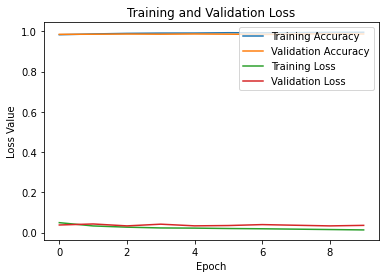

In [45]:
# accuracy train
acc = history.history['accuracy']
# accuracy test
val_acc = history.history['val_accuracy']
# loss train 
loss = history.history['loss']
# loss test
val_loss = history.history['val_loss']

def plotGraph(metric_train, metric_val, label, loc):
    plt.plot(metric_train, label='Training '+label)
    plt.plot(metric_val, label='Validation '+label)
    plt.legend(loc=loc)
    plt.ylabel(label+ ' Value')
    plt.xlabel('Epoch')
    plt.title('Training and Validation '+label)
    
plotGraph(acc, val_acc, 'Accuracy', 'lower right')
plotGraph(loss, val_loss, 'Loss', 'upper right')

# Testing the model

In [46]:
# Load the best saved model
from tensorflow.keras.models import load_model
model = load_model('./my_model.h5')

In [47]:
def classifierImage(predict):
    if predict[0] < 0.5:
        return 'Cat'
    return 'Dog'

This image below is:  Cat


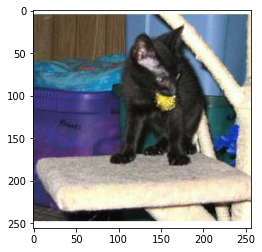

In [48]:
path_image = './dogs-vs-cats/train/cat.23.jpg'

# Turn the image into a numpy array
data = np.ndarray(shape=(1, 256, 256, 3), dtype=np.float32)
image = Image.open(path_image)
image = ImageOps.fit(image, (256, 256), Image.ANTIALIAS)
image_array = np.asarray(image)

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

# Load the image into the array
data[0] = normalized_image_array

# Run the prediction
prediction = model.predict(data)
print('This image below is: ', classifierImage(prediction))

# Show image
plt.imshow(image_array)